In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Auxiliary Functions

# Base de Dados
Montagem de casos de treinamento, validação e testes

In [3]:
df = pd.read_pickle("df_oahu.pkl")
df_ssa_clean = pd.read_pickle("df_ssa_clean.pkl")
df_ssa_residual = pd.read_pickle("df_ssa_residual.pkl")

In [5]:
interval = '2010-11'

sample_df = df.loc[interval]
residual_sample_df = df_ssa_residual.loc[interval]
clean_sample_df = df_ssa_clean.loc[interval]

week = (sample_df.index.day - 1) // 7 + 1

# PARA OS TESTES:
# 2 SEMANAS PARA TREINAMENTO
train_df = sample_df.loc[week <= 2]
train_residual_df = residual_sample_df.loc[week <= 2]
train_clean_df = clean_sample_df.loc[week <= 2]

# 1 SEMANA PARA VALIDACAO
validation_df = sample_df.loc[week == 3]
validation_residual_df = residual_sample_df.loc[week == 3]
validation_clean_df = clean_sample_df.loc[week == 3]

# 1 SEMANA PARA TESTES
test_df = sample_df.loc[week > 3]
test_residual_df = residual_sample_df.loc[week > 3]
test_clean_df = clean_sample_df.loc[week > 3]

## LSTM Data Preparation

## Differencing

In [65]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [77]:
# invert differenced value
def inverse_difference(history, yhat, index=0):
    return yhat + history[index]

## Transform to supervised learning

In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [67]:
col = 'AP_1'
diff_train_values = difference(train_df[col].values)
diff_validation_values = difference(validation_df[col].values)

# transform data to be supervised learning
train = timeseries_to_supervised(diff_train_values, 1).values
test = timeseries_to_supervised(diff_validation_values, 1).values

## Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [30]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [68]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## LSTM Model Development

In [20]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=True, shuffle=False)
        model.reset_states()
    return model

In [69]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 20)

Epoch 1/1
853/853 [==============================] - 2s 3ms/step - loss: 0.0364
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0356
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0351
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0348
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0346
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0345
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0344
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0343
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0343
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0342
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0341
Epoch 1/1
853/853 [==============================] - 2s 2ms/step - loss: 0.0340
Epoch 1/1
853/853 [=====================

In [78]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.03143489],
       [-0.02407517],
       [-0.00937614],
       [ 0.00768451],
       [ 0.02455944],
       [ 0.03975932],
       [ 0.05209019],
       [ 0.05976646],
       [ 0.06785383],
       [ 0.06562066],
       [ 0.07693379],
       [ 0.06760429],
       [ 0.059389  ],
       [ 0.06801812],
       [ 0.0763339 ],
       [ 0.06838701],
       [ 0.05067599],
       [ 0.05825183],
       [ 0.05265893],
       [ 0.04924119],
       [ 0.0562509 ],
       [ 0.09096439],
       [ 0.13799506],
       [ 0.11361901],
       [ 0.13479653],
       [ 0.16697341],
       [ 0.15659162],
       [-0.02627964],
       [-0.03238597],
       [ 0.11381258],
       [ 0.12376049],
       [-0.02870946],
       [-0.03246792],
       [ 0.00325178],
       [ 0.04729924],
       [ 0.05816032],
       [ 0.06264842],
       [ 0.13686821],
       [ 0.09634034],
       [ 0.04576185],
       [ 0.04935742],
       [ 0.04796556],
       [ 0.05682079],
       [ 0.05198339],
       [ 0.05239033],
       [ 0

## LSTM Forecast

In [23]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100

In [25]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [79]:
# walk-forward validation on the test data
predictions = list()
norm_predictions = list()
observed = validation_df[col].values

for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    norm_predictions.append(yhat)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    # invert differencing
    yhat = inverse_difference(observed, yhat, i)
   
    # store forecast
    predictions.append(yhat)
    expected = observed[i + 1]
    print('Step=%d, Predicted=%f, Expected=%f, Norm Predicted=%f' % (i+1, yhat, expected, norm_predictions[i]))

Step=1, Predicted=-0.108219, Expected=0.000000, Norm Predicted=0.061234
Step=2, Predicted=-0.198042, Expected=0.000000, Norm Predicted=0.061061
Step=3, Predicted=-0.589843, Expected=0.000000, Norm Predicted=0.060305
Step=4, Predicted=-1.170954, Expected=0.000000, Norm Predicted=0.059185
Step=5, Predicted=-1.830891, Expected=0.122812, Norm Predicted=0.057912
Step=6, Predicted=-2.366823, Expected=2.338324, Norm Predicted=0.056642
Step=7, Predicted=-0.964657, Expected=6.412881, Norm Predicted=0.055074
Step=8, Predicted=2.401419, Expected=15.360380, Norm Predicted=0.053708
Step=9, Predicted=10.497475, Expected=17.659239, Norm Predicted=0.052066
Step=10, Predicted=13.456936, Expected=135.559724, Norm Predicted=0.053340
Step=11, Predicted=120.029868, Expected=261.753852, Norm Predicted=0.031498
Step=12, Predicted=244.236019, Expected=257.572222, Norm Predicted=0.027665
Step=13, Predicted=254.607560, Expected=299.012126, Norm Predicted=0.055726
Step=14, Predicted=300.068118, Expected=362.8133

Test nRMSE: 43.267


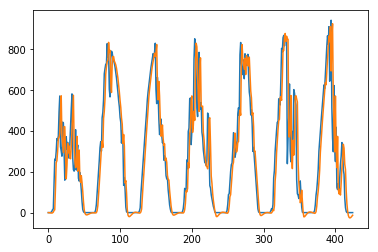

In [81]:
# report performance
y_obs = observed[2:]
y_pred = predictions[0:-1]

rmse = normalized_rmse(y_obs, y_pred)
print('Test nRMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(y_obs)
plt.plot(y_pred)
plt.show()

## Proximos passos:

https://machinelearningmastery.com/get-good-results-fast-deep-learning-time-series-forecasting/

- Avaliar com numero maior de lags

- Montar experimentos com range maior de parametros
https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

- Testar com uma MLP
https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/